Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0031 - val_loss: 4.1040e-04
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.2075e-04 - val_loss: 3.0461e-04
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1582e-04 - val_loss: 6.9849e-04
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6444e-04 - val_loss: 3.3021e-04
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3194e-04 - val_loss: 2.2650e-04
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2074e-04 - val_loss: 5.8406e-04
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.1984e-04 - val_loss: 1.1813e-04
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1395e-04 - val_loss: 6.1818e-04
Epoch 9/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1093e-04 - val_loss: 5.9634e-05
Epoch 10/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0115e-04 - val_loss: 5.0816e-04
Epoch 11/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3136e-05 - v

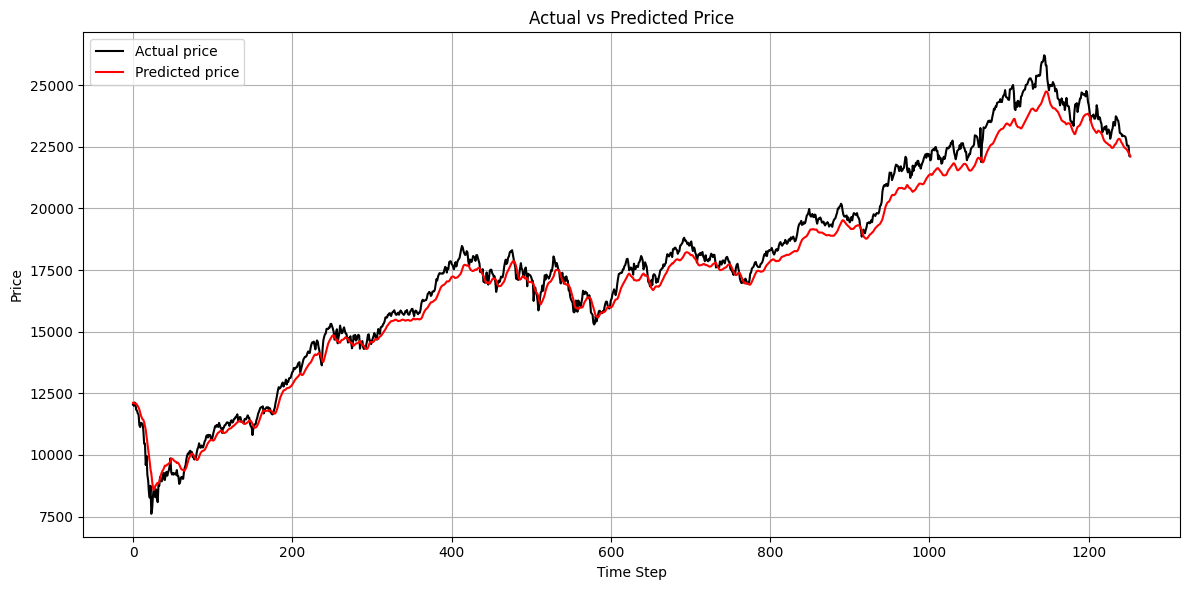

<ipython-input-5-2b3cda1be412>:137: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-5-2b3cda1be412>:138: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("zoomed_last_100.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


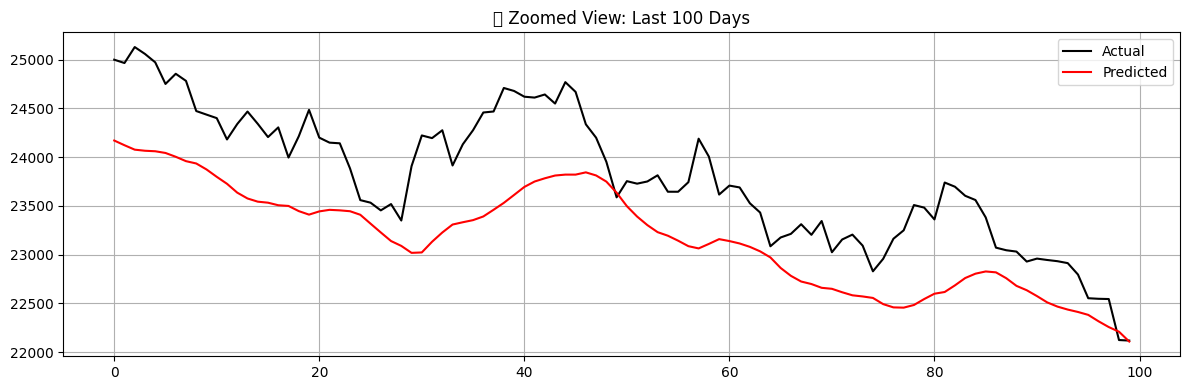

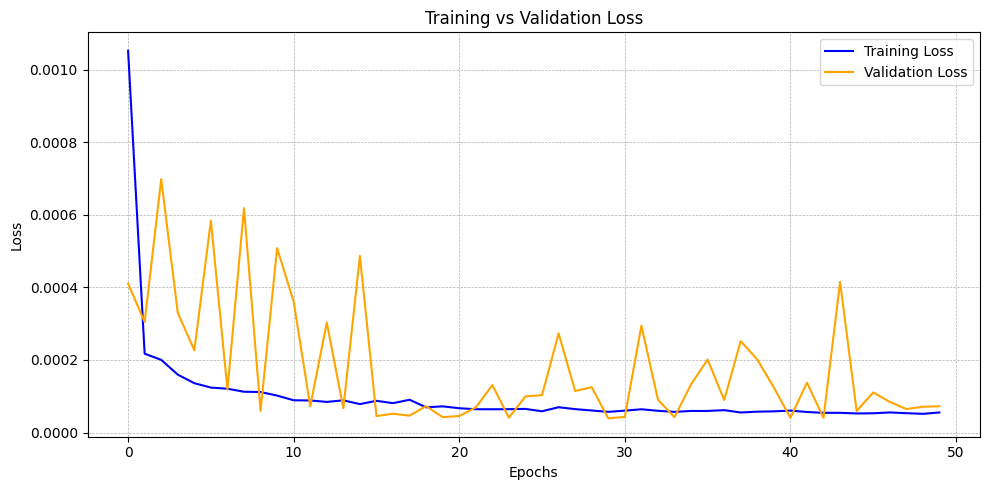

<ipython-input-5-2b3cda1be412>:174: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


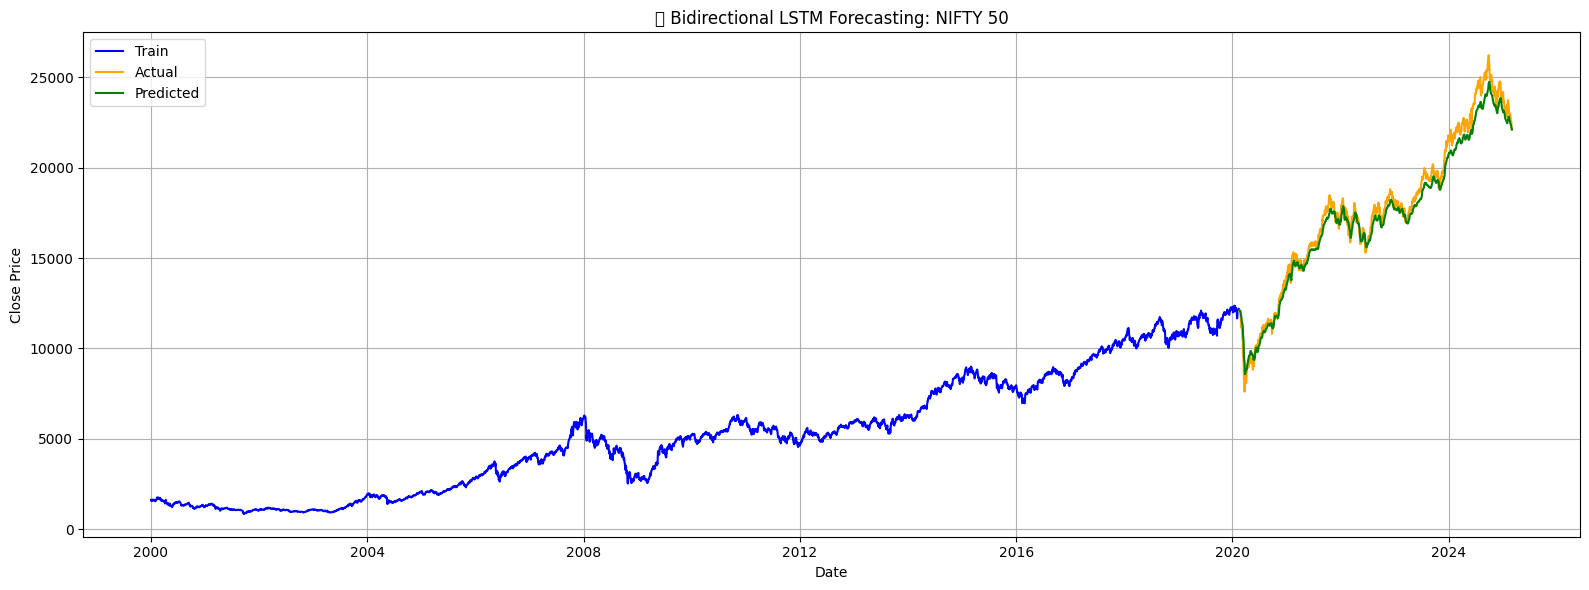

In [5]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping

# === Configuration ===
TIME_STEP = 60
BATCH_SIZE = 64
EPOCHS = 500
LSTM_UNITS = 100
FEATURE_COLUMNS = ['Close', 'Open', 'High', 'Low']
EARLY_STOPPING = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# === Load and Prepare Data ===
df = pd.read_csv('/content/NIFTY 50_Historical_PR_01012000to03032025.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Filter one index
index_name = df['Index Name'].unique()[0]
df = df[df['Index Name'] == index_name]
df.set_index('Date', inplace=True)

# Extract and scale features
features = df[FEATURE_COLUMNS].values
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# === Create Dataset ===
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i - time_step:i])
        y.append(data[i, 0])  # Close price
    return np.array(x), np.array(y)

training_data_len = int(len(scaled_features) * 0.8)
train_data = scaled_features[:training_data_len]
test_data = scaled_features[training_data_len - TIME_STEP:]

x_train, y_train = create_dataset(train_data, TIME_STEP)
x_test, y_test = create_dataset(test_data, TIME_STEP)

# === Build Bidirectional LSTM Model ===
model = Sequential([
    Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=LSTM_UNITS)),
    Dropout(0.3),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# === Train the Model ===
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[EARLY_STOPPING]
)


# === Save the Model & Weights ===
model.save("nifty_bidirectional_lstm_model.keras")  # Modern format
model.save_weights("nifty_lstm_model.weights.h5")   # Correctly named weight file
print("✅ Model and weights saved.")


# === Final Loss Values ===
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\n📉 Final Training Loss: {final_train_loss:.6f}")
print(f"📉 Final Validation Loss: {final_val_loss:.6f}")

# === Predictions ===
predictions = model.predict(x_test)

# === Rescale Close Price ===
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
predictions_rescaled = close_scaler.inverse_transform(predictions)
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# === Evaluation ===
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"\n📊 Evaluation Metrics:")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ R²  : {r2:.4f}")

# === Print Evaluation Table (Current Run) ===
eval_table = pd.DataFrame({
    'Features': [' – '.join(FEATURE_COLUMNS)],
    'Epoc.': [len(history.history['loss'])],
    'RMSE': [rmse],
    'MSE': [mse],
    'MAE': [mae],
    'R²': [r2]
})

print("\n📋 Error Value Table for Current Run:")
print(eval_table.to_string(index=False))

# === Plot Actual vs Predicted ===
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='black', label='Actual price')
plt.plot(predictions_rescaled, color='red', label='Predicted price')
plt.title('Actual vs Predicted Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
plt.show()

# === Plot Zoomed-in Last 100 Predictions ===
plt.figure(figsize=(12, 4))
plt.plot(y_test_rescaled[-100:], label='Actual', color='black')
plt.plot(predictions_rescaled[-100:], label='Predicted', color='red')
plt.title("🔍 Zoomed View: Last 100 Days")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("zoomed_last_100.png")
plt.show()

# === Plot Training vs Validation Loss Curve ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("training_vs_validation_loss.png")
plt.show()



# # 📈 NIFTY 50 Price Prediction using Bidirectional LSTM

In [6]:
! pip install tensorflow

  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.0.1-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.17.2-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.71.0-cp39-cp39-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl.metadata (14 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.wh

# ## 📦 1. Imports and Configuration

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.callbacks import EarlyStopping


# --- Configuration Parameters ---

In [9]:
TIME_STEP = 60
BATCH_SIZE = 64
EPOCHS = 500
LSTM_UNITS = 100
FEATURE_COLUMNS = ['Close', 'Open', 'High', 'Low']
EARLY_STOPPING = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# ## 📂 2. Load and Prepare Data

In [12]:
df = pd.read_csv(r'C:\Users\punee\Desktop\mini-project\stockpredictionmodel\NIFTY 50_Historical_PR_01012000to03032025.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Filter to a single index
index_name = df['Index Name'].unique()[0]
df = df[df['Index Name'] == index_name]
df.set_index('Date', inplace=True)

# Extract and scale features
features = df[FEATURE_COLUMNS].values
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# ## 🛠️ 3. Create Dataset for LSTM

In [13]:
def create_dataset(data, time_step=60):
    x, y = [], []
    for i in range(time_step, len(data)):
        x.append(data[i - time_step:i])
        y.append(data[i, 0])  # Close price
    return np.array(x), np.array(y)

training_data_len = int(len(scaled_features) * 0.8)
train_data = scaled_features[:training_data_len]
test_data = scaled_features[training_data_len - TIME_STEP:]

x_train, y_train = create_dataset(train_data, TIME_STEP)
x_test, y_test = create_dataset(test_data, TIME_STEP)

# ## 🧠 4. Build Bidirectional LSTM Model

In [14]:
model = Sequential([
    Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(units=LSTM_UNITS)),
    Dropout(0.3),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\punee\anaconda3\envs\miniproj_env\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# ## 🏋️ 5. Train and save the Model

In [6]:
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[EARLY_STOPPING]
)


model.save("nifty_bidirectional_lstm_model.keras")
model.save_weights("nifty_lstm_model.weights.h5")
print("\u2705 Model and weights saved.")

Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0043 - val_loss: 8.0296e-04
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.7423e-04 - val_loss: 4.9664e-04
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0061e-04 - val_loss: 5.2431e-04
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.5662e-04 - val_loss: 2.2982e-04
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4174e-04 - val_loss: 1.5862e-04
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1705e-04 - val_loss: 9.6804e-05
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2745e-04 - val_loss: 7.5021e-05
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2833e-04 - val_loss: 7.0541e-05
Epoch 9/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0283e-04 - val_loss: 3.6357e-04
Epoch 10/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0832e-04 - val_loss: 1.2289e-04
Epoch 11/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8

# ## 📉 6. Final Loss Values

In [12]:
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\n📉 Final Training Loss: {final_train_loss:.6f}")
print(f"📉 Final Validation Loss: {final_val_loss:.6f}")



📉 Final Training Loss: 0.000042
📉 Final Validation Loss: 0.000282


# ## 📈 8. Predictions

In [15]:
model.load_weights(r"C:\Users\punee\Desktop\mini-project\stockpredictionmodel\best.h5")

predictions = model.predict(x_test)

# Rescale Close Price
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
predictions_rescaled = close_scaler.inverse_transform(predictions)
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


# ## 📊 9. Evaluation Metrics

In [17]:
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"\n📊 Evaluation Metrics:")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MSE : {mse:.4f}")
print(f"✅ MAE : {mae:.4f}")
print(f"✅ R²  : {r2:.4f}")

# === Print Evaluation Table (Current Run) ===
eval_table = pd.DataFrame({
    'Features': [' – '.join(FEATURE_COLUMNS)],
    # 'Epoc.': [len(history.history['loss'])],
    'RMSE': [rmse],
    'MSE': [mse],
    'MAE': [mae],
    'R²': [r2]
})

print("\n📋 Error Value Table for Current Run:")
print(eval_table.to_string(index=False))


📊 Evaluation Metrics:
✅ RMSE: 563.5903
✅ MSE : 317633.9803
✅ MAE : 467.0814
✅ R²  : 0.9821

📋 Error Value Table for Current Run:
                 Features       RMSE           MSE        MAE       R²
Close – Open – High – Low 563.590259 317633.980266 467.081352 0.982124


# ## 📉 10. Plot Actual vs Predicted Prices

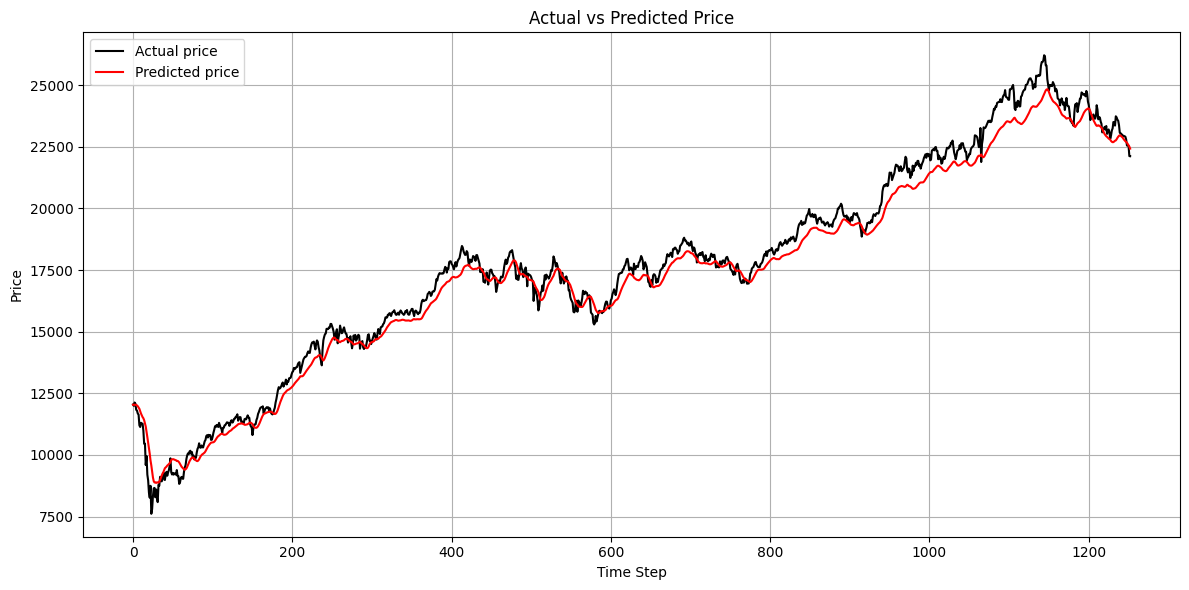

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='black', label='Actual price')
plt.plot(predictions_rescaled, color='red', label='Predicted price')
plt.title('Actual vs Predicted Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
plt.show()

# ## 🔍 11. Zoomed-in View: Last 100 Predictions

C:\Users\punee\AppData\Local\Temp\ipykernel_76972\2104452607.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\punee\AppData\Local\Temp\ipykernel_76972\2104452607.py:8: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("zoomed_last_100.png")
c:\Users\punee\anaconda3\envs\miniproj_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


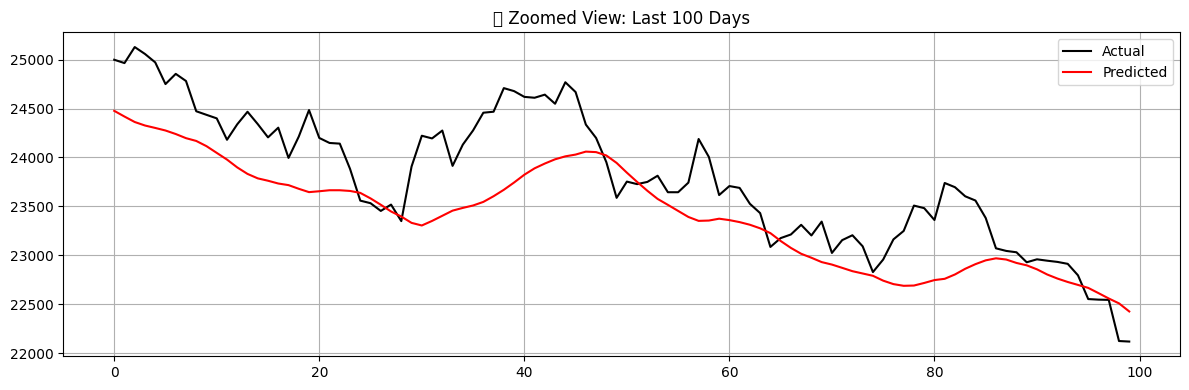

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_rescaled[-100:], label='Actual', color='black')
plt.plot(predictions_rescaled[-100:], label='Predicted', color='red')
plt.title("🔍 Zoomed View: Last 100 Days")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("zoomed_last_100.png")
plt.show()

# ## 📉 13. Training vs Validation Loss

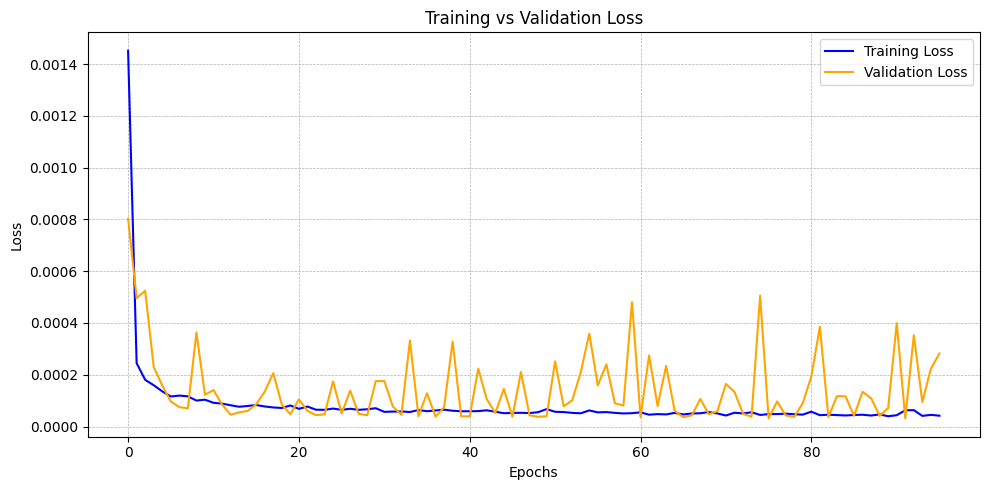

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("training_vs_validation_loss.png")
plt.show()
